In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [5]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

We study the completeness of LSBG detection. This completeness is a product of 1) Johnny's detection completeness matrix; 2) completeness of vanilla scarlet (deblending step); 3) completeness of Spergel/monolet scarlet (modeling step). 

We obtain the completeness matrix of 2 and 3 by injecting mock LSBGs (all Sersics).

### 1. Johnny's completeness map for detection

In [5]:
from scipy.interpolate import interp1d, interp2d
from scipy.stats import binned_statistic, binned_statistic_2d

[1.25, 20.75, 23.0, 28.5]


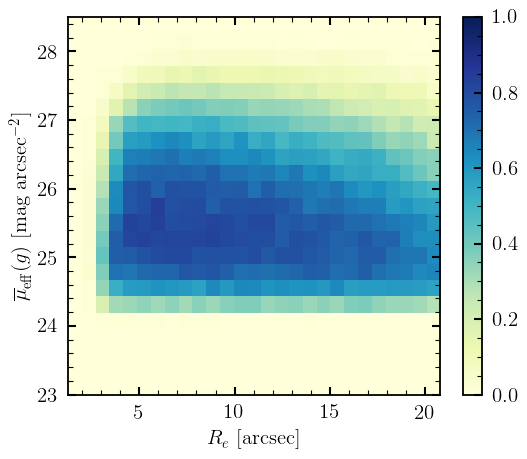

In [7]:
x = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness-x.txt')
y = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness-y.txt')
greco_comp_map = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness.txt') / 100

# 2d interpolation
f_greco = interp2d(x, y, greco_comp_map)

plt.imshow(greco_comp_map, 
           extent=[min(x), max(x), min(y), max(y)], 
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

plt.xlabel(r'$R_{e}$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.colorbar()

print([min(x), max(x), min(y), max(y)])

## Analyze mock gals

### The effect of deblending (vanilla scarlet) -> completeness term

In [33]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')

# Running vanilla scarlet
method = 'vanilla'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+250}_nosegmap.fits' 
    for start in [0, 250, 500, 750]]
files += ['./Catalog/mock_sample/vanilla/_lsbg_meas_vanilla_monotonic_vanilla_1000_2000_nosegmap.fits']
meas_cat = vstack([Table.read(file) for file in files])

files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+250}_segmap.fits' 
    for start in [0, 250, 500, 750]]
files += ['./Catalog/mock_sample/vanilla/_lsbg_meas_vanilla_monotonic_vanilla_1000_2000_segmap.fits']
seg_meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]
seg_meas_cat = seg_meas_cat[~bad_flag]
print('Number of survived objs after modeling and file flag:', len(obj_cat))

Total number of objects: 2000
Number of survived objs after modeling and file flag: 1975


In [34]:
# udg_cat = Table.read(f'{TIGRESS}/Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits')

The purpose of this "deblending" step is to remove junks as much as possible. We generated mock Sersics (n=1) which should not be removed in this step. Therefore, we first run vanilla scarlet on mock galaxies, then apply cuts to them based on the output catalog of vanilla scarlet. Apparently, some of the mock gals will be removed in this way. Then we calculate the fraction of removed galaxies. 

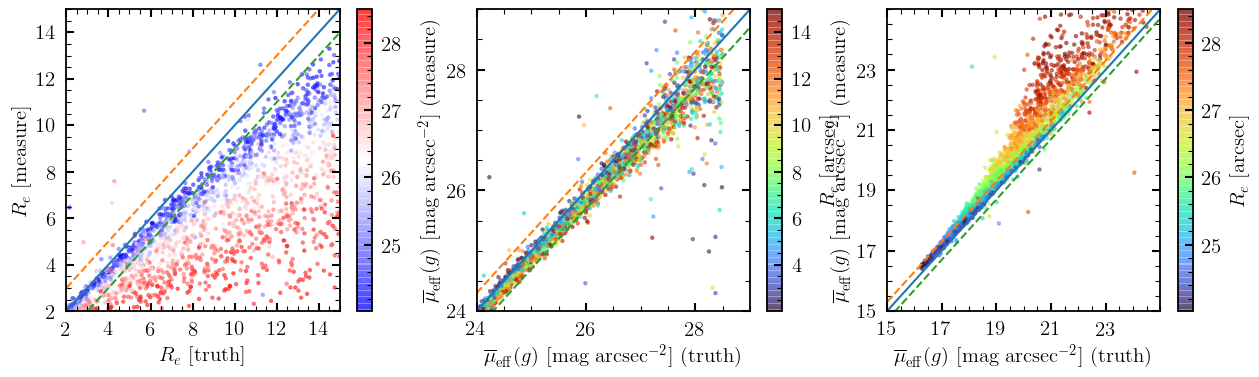

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

re_meas = meas_cat['rhalf_circularized'].data * 0.168 
re_truth =  params_cat['rhalf_circularized'].data

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

plt.scatter(mag_truth, mag_meas, c=SB_truth, s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.2)

In [36]:
# To apply cuts, see `nsa_z002_004/NSA-structure-vanilla-cuts.ipynb` for details
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [43]:
# The criteria below is also from `nsa_z002_004/NSA-structure-vanilla-cuts.ipynb`
color_bound = [0.1, 1.2]
half_width = 0.25

# Color cuts
mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

# Size cuts
min_size = 1.8
max_size = 12
mask &= (meas_cat['rhalf_circularized'] >= min_size /
         0.168) & (meas_cat['rhalf_circularized'] <= max_size / 0.168)

# SB cuts
min_cen_SB = 22.
min_eff_SB = 23.0
mask &= (meas_cat['SB_0'][:, 0] > 22.0)
mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0)  # Cuts based on JG votes

# Shape cuts
mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
# mask &= ~((meas_cat['M20'] < -1.6) & (
#     meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
#mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)
#mask &= (meas_cat['A_outer'] <= 0.13)

# mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

In [44]:
bin_num = [8, 8]
_range = [[2, 12], [24, 28.5]]
_extent = [item for sublist in _range for item in sublist]

In [45]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_truth_cuts = binned_statistic_2d(
    params_cat['rhalf_circularized'].data[mask],
    params_cat['SB_eff_g'].data[mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas_cuts = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data[mask] * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0][mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

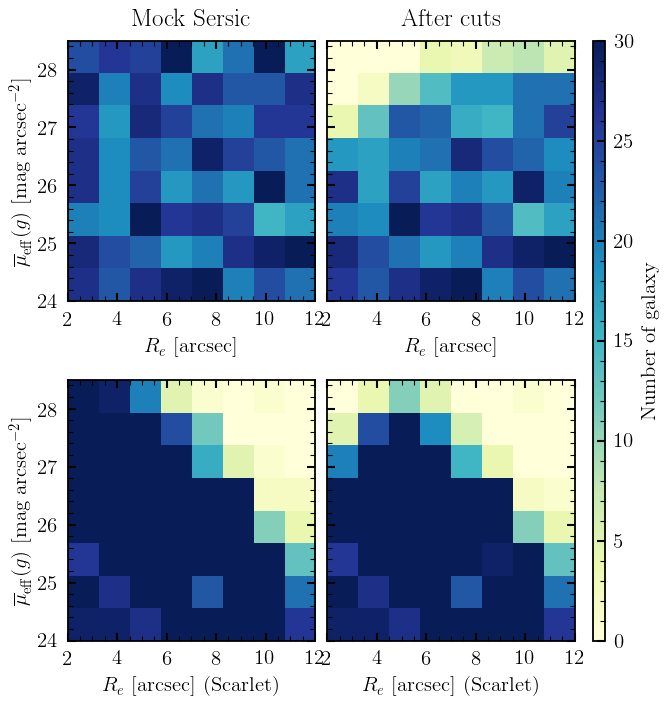

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=False)

# In original size
plt.sca(axes[0, 0])
plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=30)

plt.sca(axes[0, 1])
plt.imshow(res_truth_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=30)

# In measured size
plt.sca(axes[1, 0])
plt.imshow(res_meas.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=30)

plt.sca(axes[1, 1])
im = plt.imshow(res_meas_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=30)
# plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
#             udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')
for ax in axes[1]:
    ax.set_xlabel(r'$R_e$ [arcsec] (Scarlet)')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

axes[0, 0].set_title('Mock Sersic')
axes[0, 1].set_title('After cuts')


# # CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Number of galaxy')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

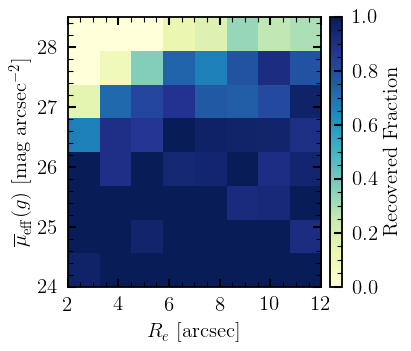

In [16]:
fig, ax = plt.subplots(figsize=(3, 2.7))

deblend_map = np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0)
im = plt.imshow(deblend_map,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

# plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
#             udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

ax.set_xlim(_range[0])
ax.set_ylim(_range[1])
ax.set_xticks(np.arange(2, 13, 2))

ax.set_xlabel(r'$R_e$ [arcsec]')
ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

## CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.04, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [17]:
import pickle

In [18]:
# save the completeness
with open('./Catalog/completeness/completeness_vanilla_scarlet.pkl', 'wb') as f:
    pickle.dump((deblend_map, _extent, res_truth_cuts.x_edge, res_truth_cuts.y_edge), f)

### The effect of modeling (spergel scarlet)

In [6]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')[0:2000]

# Modeling using spergel profile
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+200}_nosegmap.fits' 
    for start in [0, 200, 400, 600, 800]]
files += [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+250}_nosegmap.fits' 
    for start in [1000, 1250, 1500, 1750]]
meas_cat = vstack([Table.read(file) for file in files])

files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+200}_segmap.fits' 
    for start in [0, 200, 400, 600, 800]]
files += [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+250}_segmap.fits' 
    for start in [1000, 1250, 1500, 1750]]
seg_meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')[0:2000]

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
# bad_flag |= (params_cat['SB_eff_g'] > 27.5)

obj_cat = obj_cat[~bad_flag]#[mask]
params_cat = params_cat[~bad_flag]#[mask]
meas_cat = meas_cat[~bad_flag]#[mask]
seg_meas_cat = seg_meas_cat[~bad_flag]#[mask]

print('Number of survived objs after modeling:', len(obj_cat))

Total number of objects: 2000
Number of survived objs after modeling: 1974


In [224]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')[0:2000]

# Modeling using spergel profile
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+500}_nosegmap.fits' 
    for start in [0, 500, 1000, 1500]]
meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')[0:2000]

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
bad_flag |= (params_cat['SB_eff_g'] > 27)

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]

print('Number of survived objs after modeling:', len(obj_cat))

Total number of objects: 2000
Number of survived objs after modeling: 1320


In [225]:
meas_cat['rhalf_spergel'] = 0.168 * meas_cat['rhalf_spergel']
meas_cat['rhalf_circularized'] = 0.168 * meas_cat['rhalf_circularized']
meas_cat['sersic_rhalf'] = 0.168 * meas_cat['sersic_rhalf']

In [137]:
meas_cat['ID'][np.where((np.abs(re_meas - re_truth) > 4) & (SB_truth < 27.5))[0]].data

IndexError: index 396 is out of bounds for axis 0 with size 371

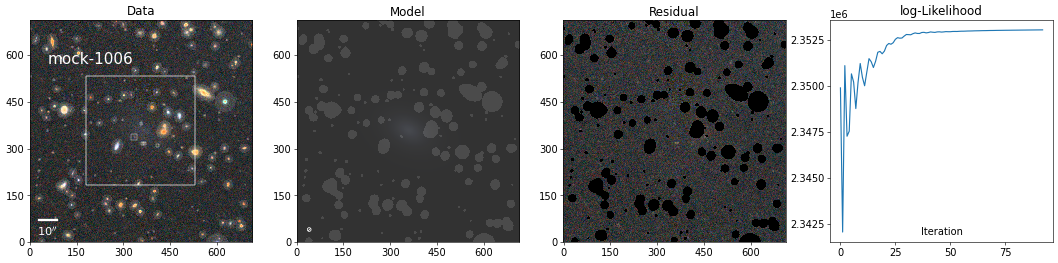

In [113]:
from PIL import Image
ind = 1006
Image.open(f'./Figure/mock_sample/spergel/mock-{ind}-zoomin-spergel.png')

# import pickle
# with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
#     gal = pickle.load(fp)
# gal.display(stretch=0.8)

In [114]:
params_cat[params_cat['viz-id'] == ind]

viz-id,SB_eff_g,mag_g,ellip,sersic_n,g-i,g-r,rhalf_circularized
int64,float64,float64,float64,float64,float64,float64,float64
1006,27.115244540330337,19.42368560026964,0.32013266013214764,1.1107193748834523,0.3899626925276661,0.2795795641955202,13.779131786256388


In [115]:
meas_cat[meas_cat['ID'] == ind][
    ['ID', 'rhalf_spergel', 'rhalf_circularized', 
               "ell_sym", 'sersic_rhalf', 'sersic_n']
 ]

ID,rhalf_spergel,rhalf_circularized,ell_sym,sersic_rhalf,sersic_n
int64,float64,float64,float64,float64,float64
1006,9.209049183051082,9.088199456372854,0.30310128656742796,11.12454735137078,0.7910497139347664


-0.3296601445855272 0.792533745011053


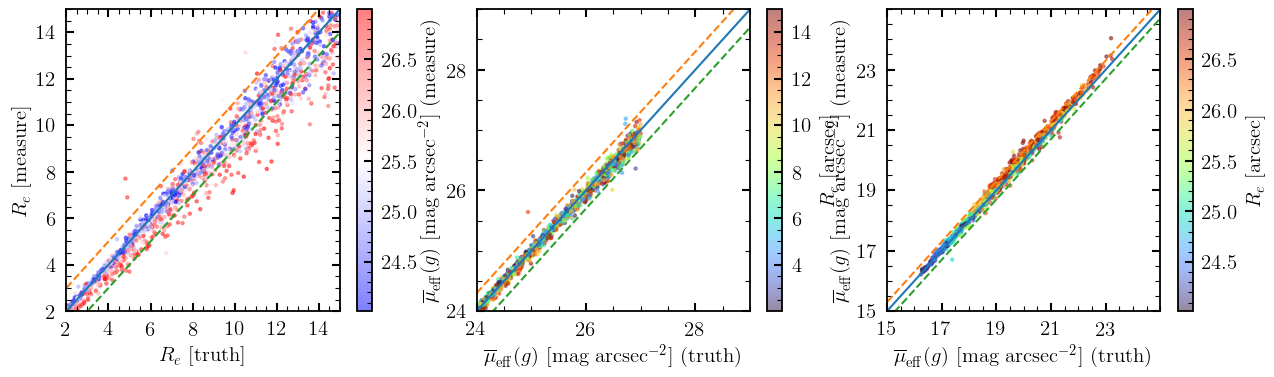

In [226]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

plt.scatter(mag_truth, mag_meas, c=SB_truth, s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.2)

no sky: 0.45745995209383045 2.655258138598614

In [ ]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/gen_cutout/mock_sample/')
from gen_mock_gal import gen_mock_gal
gen_mock_gal(4000, 5000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Start to generate mock galaxies...


 18%|█▊        | 183/1000 [13:05<58:17,  4.28s/it]  

Incomplete file for bkgid = 4183
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4183_g.fits'


 20%|█▉        | 196/1000 [13:54<53:11,  3.97s/it]

Incomplete file for bkgid = 4196
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4196_g.fits'


 24%|██▎       | 237/1000 [16:41<53:06,  4.18s/it]

Incomplete file for bkgid = 4237
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4237_g.fits'


 26%|██▌       | 256/1000 [17:57<53:05,  4.28s/it]

Incomplete file for bkgid = 4256
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4256_g.fits'


 33%|███▎      | 331/1000 [23:08<45:25,  4.07s/it]

Incomplete file for bkgid = 4331
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4331_g.fits'


 35%|███▌      | 354/1000 [24:42<45:23,  4.22s/it]

Incomplete file for bkgid = 4354
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4354_g.fits'


 44%|████▎     | 437/1000 [30:36<40:53,  4.36s/it]

Incomplete file for bkgid = 4437
[Errno 2] No such file or directory: './Cutout/mock_sample/bkg/mockbkg_4437_g.fits'


 44%|████▍     | 441/1000 [30:49<37:21,  4.01s/it]

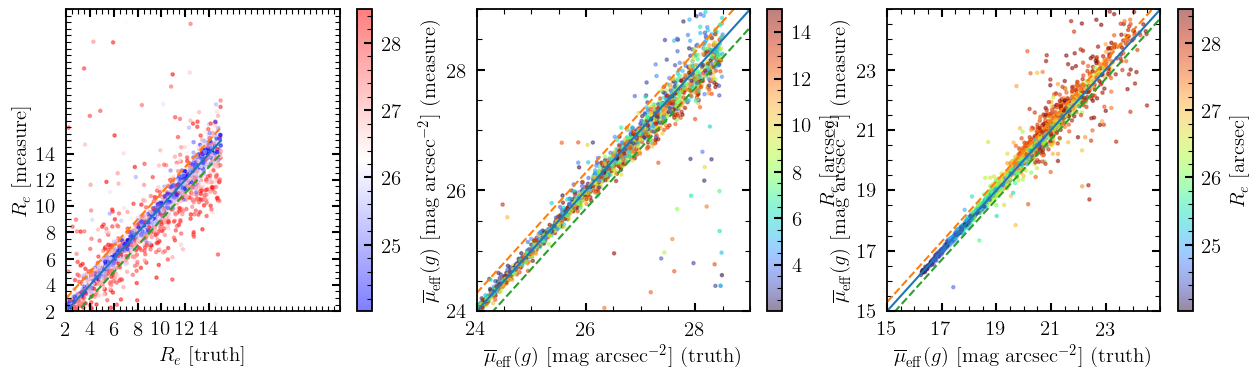

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

re_meas = meas_cat['rhalf_spergel'].data * 0.168 
re_truth =  params_cat['rhalf_circularized'].data

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 25)
plt.ylim(2, 25)

# compare SB_eff
plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

plt.scatter(mag_truth, mag_meas, c=SB_truth, s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.2)

In [49]:
meas_cat[
    (meas_cat['C'].data > 3.0) * ((0.168 * meas_cat['rhalf_spergel'].data) < 4.0) & (
        (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]) < 0.9)
]

ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,rhalf_spergel,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
678,4.6152705213097915 .. 6.091230077165823,25.33950709495442 .. 25.038237490182418,4.536137212902759 .. 4.536137212902759,4.597808830271633 .. 4.597808830271633,28.00657978182757 .. 28.00657978182757,30.18781734777309 .. 30.18781734777309,29.209554668665177 .. 29.209554668665177,28.63934891654923 .. 28.63934891654923,372.9453598010229,345.8292038393583,372.86399842369815,345.88011871502215,0.8106637799705939,0.8106644636848923,-0.6974556349712988,-0.6974533668344415,14.590935274484126,24.91651105280826,10.841847569143036,8.820094161820911,6.180498544366413,13.754399989052938,26.504478524966657,0.5841137008295292,-1.6219197105329017,0.05535317850547017,0.02582572405716055,3.1614787771790636,0.008107042763295049,0.013873663876620373,0.4938418899853652,0.08027043278734675,0.9310114769044733,24.055147056786648,0.8764254806444612,2.4441233087346825,372.9206993865823,345.84357266871467,0.005544675654581881,0.0,0.0
731,84.91636811913116 .. 236.2035244098979,22.17752147230933 .. 21.066784066336837,79.01897769253239 .. 79.01897769253239,79.70703036977582 .. 79.70703036977582,23.91784843960221 .. 23.91784843960221,26.811623143818526 .. 26.811623143818526,26.730786826422786 .. 26.730786826422786,25.690429213189528 .. 25.690429213189528,338.46166884125785,343.34548227919794,338.4374755283494,343.3665480078033,0.3820690843344714,0.38206891945447274,-1.3293077935765671,-1.329305737004626,12.071759850019479,14.95773161025851,11.758062279831625,10.463610439963688,4.272452450775439,10.745315796815829,22.238312190142263,0.5630992972316539,-2.1144552949335695,0.29265904068564996,-0.06344098173642887,3.5821229234458545,0.017573509849644474,0.018664016511393704,0.38191047305693426,0.02412075063601965,4.4777372873975665,20.673983790316065,0.4580927633877836,1.799734819915835,338.42742504975166,343.37532412262846,0.01837267110252565,0.0,0.0
1117,13.872078139567344 .. 34.98744132768033,24.144646183845097 .. 23.14021954204229,12.90640503325267 .. 32.55187033327146,12.900649128420993 .. 32.53735308642785,27.562617965028924 .. 26.55819132322611,30.243015234132137 .. 29.23858859232933,28.784597292026877 .. 27.780170650224065,27.938032758637355 .. 26.933606116834547,357.05257826479095,357.51223575007555,357.82193583509917,357.9205742761919,0.8660932245757896,0.8661289210972232,0.5271783580805216,0.5271550497233051,24.55195720931388,40.07620047177829,14.663239298260272,13.623167583089595,9.930683041688972,24.53171307142511,48.20195858190242,0.6656334943371496,-1.5646505174466552,0.4191886055594223,0.11449073746869304,3.4304278225307527,0.027966113243083124,0.05210720295397591,0.6420849469384207,0.16641851400973198,0.8226233438281951,44.32710637334256,0.9168165160611184,0.5247420673818045,357.6982569822204,357.8246671321049,0.007407741661674627,0.0,0.0
1180,9.898904241683839 .. 22.74897913108304,24.511032192326347 .. 23.607595219240814,7.64539727450695 .. 17.570124813836212,7.629642085017218 .. 17.53391732377899,28.069303058743124 .. 27.165866085657594,31.133996323877334 .. 30.2305593507918,29.246684759865275 .. 28.34324778677974,28.29367510274854 .. 27.390238129663008,374.3694607687022,363.5035352794827,374.0000000616339,363.32013737559146,0.9042179582733615,0.9041984770300462,0.25679974041543546,0.2568229273719716,29.045766610180237,44.46654687954038,13.7632

#### interpolate: study $\Delta \mathrm{SB} - \mathrm{SB}$ relation

In [143]:
np.log10(0.0134)

-1.8728952016351923

In [ ]:
X = SB_truth
y = SB_truth - SB_meas

# remove outliers
flag = ((X > 23) & (X < 28.7) & (np.abs(y) < 10))
X = X[flag]
y = y[flag]

# Binned stats
n_bins = 15
res_count = binned_statistic(X, y, statistic='count', range=(24, 28.7), bins=n_bins)
res_med = binned_statistic(X, y, statistic='median', range=(24, 28.7), bins=n_bins)
res_std = binned_statistic(X, y, statistic='std', range=(24, 28.7), bins=n_bins)

In [ ]:
plt.scatter(X, y, s=2, color='k', label='Data')
plt.axhline(0)

_cen = 0.5 * (res_count.bin_edges[:-1] + res_count.bin_edges[1:])
plt.errorbar(_cen, res_med.statistic, yerr=res_std.statistic)

X_test = np.linspace(24, 28.7, 100)

f_med = interp1d(_cen, np.nan_to_num(res_med.statistic, 0), kind='quadratic', bounds_error=False, fill_value='extrapolate')
f_std = interp1d(_cen, np.nan_to_num(res_std.statistic, 0), kind='quadratic', bounds_error=False, fill_value='extrapolate')

plt.fill_between(X_test, 
                 f_med(X_test) - f_std(X_test),
                 f_med(X_test) + f_std(X_test), alpha=0.2)

plt.ylim(-4, 4)

In [364]:
with open('./Catalog/completeness/SB_meas_err.pkl', 'wb') as f:
    pickle.dump((f_med, f_std), f)

#### interpolate: study $\Delta R_e - \mathrm{SB}$ relation

In [365]:
X = SB_truth
y = re_truth - re_meas

# remove outliers
flag = ((X > 23) & (X < 28.7) & (np.abs(y) < 10))
X = X[flag]
y = y[flag]

# Binned stats
n_bins = 15
res_count = binned_statistic(X, y, statistic='count', range=(24, 28.7), bins=n_bins)
res_med = binned_statistic(X, y, statistic='median', range=(24, 28.7), bins=n_bins)
res_std = binned_statistic(X, y, statistic='std', range=(24, 28.7), bins=n_bins)

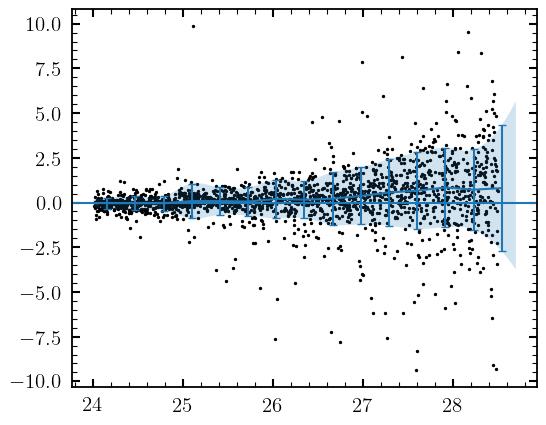

In [366]:
plt.scatter(X, y, s=2, color='k', label='Data')
plt.axhline(0)

_cen = 0.5 * (res_count.bin_edges[:-1] + res_count.bin_edges[1:])
plt.errorbar(_cen, res_med.statistic, yerr=res_std.statistic)

X_test = np.linspace(24, 28.7, 100)
f_med = interp1d(_cen, res_med.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')
f_std = interp1d(_cen, res_std.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')

plt.fill_between(X_test, 
                 f_med(X_test) - f_std(X_test),
                 f_med(X_test) + f_std(X_test), alpha=0.2)

In [367]:
with open('./Catalog/completeness/Re_meas_err.pkl', 'wb') as f:
    pickle.dump((f_med, f_std), f)

#### interpolate: study $\Delta m - m$ relation

In [375]:
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

X = mag_meas
y = mag_truth - mag_meas

# remove outliers
flag = ((X > 16) & (X < 25) & (np.abs(y) < 10))
X = X[flag]
y = y[flag]

# Binned stats
n_bins = 15
res_count = binned_statistic(X, y, statistic='count', range=(16, 25), bins=n_bins)
res_med = binned_statistic(X, y, statistic='median', range=(16, 25), bins=n_bins)
res_std = binned_statistic(X, y, statistic='std', range=(16, 25), bins=n_bins)

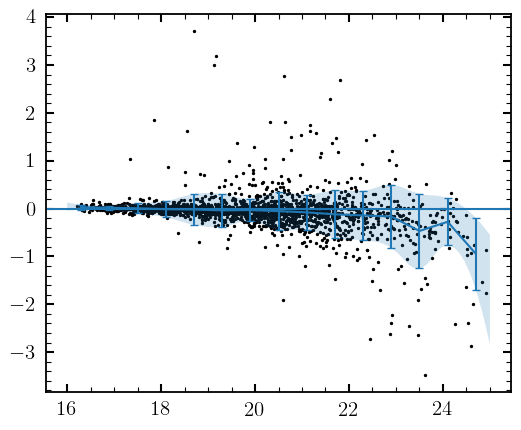

In [376]:
plt.scatter(X, y, s=2, color='k', label='Data')
plt.axhline(0)

_cen = 0.5 * (res_count.bin_edges[:-1] + res_count.bin_edges[1:])
plt.errorbar(_cen, res_med.statistic, yerr=res_std.statistic)

X_test = np.linspace(16, 25, 100)
f_med = interp1d(_cen, res_med.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')
f_std = interp1d(_cen, res_std.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')

plt.fill_between(X_test, 
                 f_med(X_test) - f_std(X_test),
                 f_med(X_test) + f_std(X_test), alpha=0.2)

In [377]:
with open('./Catalog/completeness/mag_g_meas_err.pkl', 'wb') as f:
    pickle.dump((f_med, f_std), f)

#### interpolate: study $\Delta (g-i) - (g-i)$ relation

In [380]:
gi_meas = meas_cat['mag'].data[:, 0] - meas_cat['mag'].data[:, 2]
gi_truth = params_cat['g-i'].data

X = gi_meas
y = gi_truth - gi_meas

# remove outliers
flag = ((X > 0.1) & (X < 1.3) & (np.abs(y) < 10))
X = X[flag]
y = y[flag]

# Binned stats
n_bins = 15
res_count = binned_statistic(X, y, statistic='count', range=(0.1, 1.3), bins=n_bins)
res_med = binned_statistic(X, y, statistic='median', range=(0.1, 1.3), bins=n_bins)
res_std = binned_statistic(X, y, statistic='std', range=(0.1, 1.3), bins=n_bins)

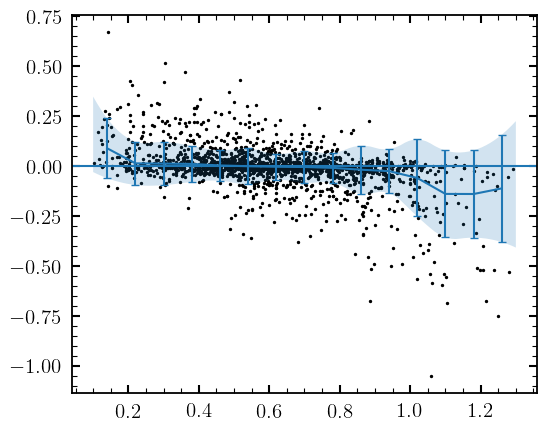

In [381]:
plt.scatter(X, y, s=2, color='k', label='Data')
plt.axhline(0)

_cen = 0.5 * (res_count.bin_edges[:-1] + res_count.bin_edges[1:])
plt.errorbar(_cen, res_med.statistic, yerr=res_std.statistic)

X_test = np.linspace(0.1, 1.3, 100)
f_med = interp1d(_cen, res_med.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')
f_std = interp1d(_cen, res_std.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')

plt.fill_between(X_test, 
                 f_med(X_test) - f_std(X_test),
                 f_med(X_test) + f_std(X_test), alpha=0.2)

In [382]:
with open('./Catalog/completeness/gi_meas_err.pkl', 'wb') as f:
    pickle.dump((f_med, f_std), f)

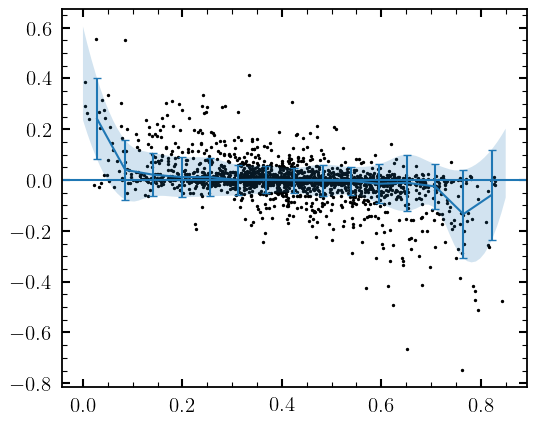

In [386]:
gr_meas = meas_cat['mag'].data[:, 0] - meas_cat['mag'].data[:, 1]
gr_truth = params_cat['g-r'].data

X = gr_meas
y = gr_truth - gr_meas

# remove outliers
flag = ((X > 0.0) & (X < 0.85) & (np.abs(y) < 10))
X = X[flag]
y = y[flag]

# Binned stats
n_bins = 15
res_count = binned_statistic(X, y, statistic='count', range=(0.0, 0.85), bins=n_bins)
res_med = binned_statistic(X, y, statistic='median', range=(0.0, 0.85), bins=n_bins)
res_std = binned_statistic(X, y, statistic='std', range=(0.0, 0.85), bins=n_bins)

### Plot
plt.scatter(X, y, s=2, color='k', label='Data')
plt.axhline(0)

_cen = 0.5 * (res_count.bin_edges[:-1] + res_count.bin_edges[1:])
plt.errorbar(_cen, res_med.statistic, yerr=res_std.statistic)

X_test = np.linspace(0.0, 0.85, 100)
f_med = interp1d(_cen, res_med.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')
f_std = interp1d(_cen, res_std.statistic, kind='quadratic', bounds_error=False, fill_value='extrapolate')

plt.fill_between(X_test, 
                 f_med(X_test) - f_std(X_test),
                 f_med(X_test) + f_std(X_test), alpha=0.2)

In [387]:
with open('./Catalog/completeness/gr_meas_err.pkl', 'wb') as f:
    pickle.dump((f_med, f_std), f)

---

We don't apply any cuts on the spergel catalog to rule out junks. 

In [249]:
bin_num = [8, 8]
_range = [[2, 12], [24, 28.5]]
_extent = [item for sublist in _range for item in sublist]

In [250]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

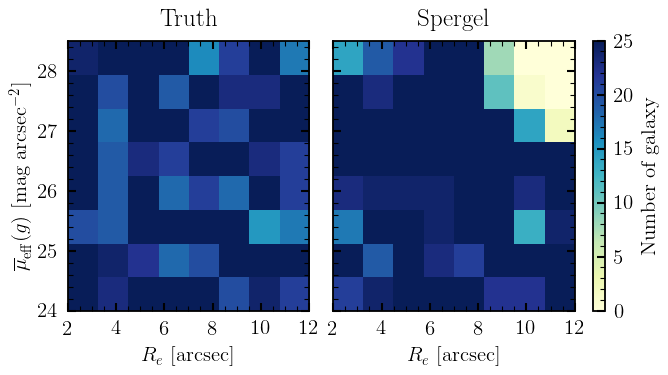

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.7), sharey=True, sharex=False)

# In original size
plt.sca(axes[0])
im = plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=25)

# In measured size
plt.sca(axes[1])
im = plt.imshow(res_meas.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=25)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')
    

axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[0].set_title('Truth')
axes[1].set_title('Spergel')


# # CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Number of galaxy')

plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [256]:
ratio_set = []
for i in range((bin_num[0] + 2)**2):
    ratio_set.append(np.sum(np.in1d(
        params_cat[res_truth.binnumber == i]['viz-id'].data, 
        params_cat[res_meas.binnumber == i]['viz-id'].data)) / len(
        params_cat[res_truth.binnumber == i]['viz-id'].data))
    
ratio_set = np.array(ratio_set).reshape(bin_num[0] + 2, bin_num[0] + 2).T
ratio_set = ratio_set[1:-1, 1:-1]
deblend_modeling_map = np.nan_to_num(ratio_set, 0)

In [257]:
detection_map = f_greco((res_truth.x_edge[1:] + res_truth.x_edge[:-1])
                       / 2, (res_truth.y_edge[1:]
                       + res_truth.y_edge[:-1]) / 2)

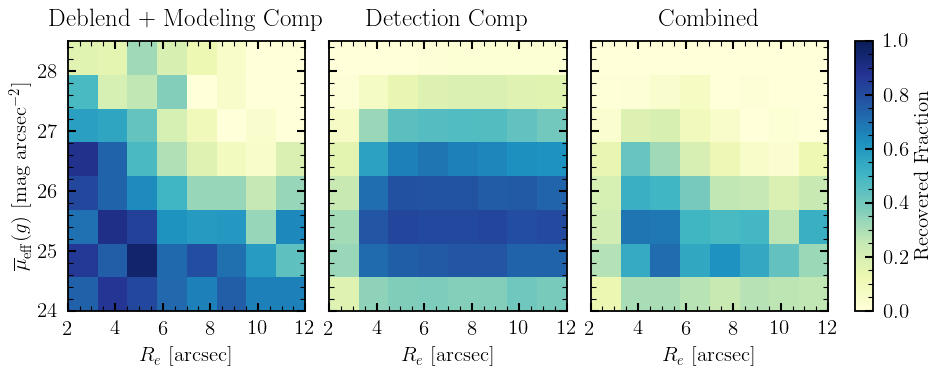

In [258]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.7), sharey=True, sharex=False)

# Deblend + Modeling completeness
plt.sca(axes[0])
im = plt.imshow(deblend_modeling_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                cmap='YlGnBu')

# Greco's detection completeness
plt.sca(axes[1])
plt.imshow(
    detection_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )

# Together
plt.sca(axes[2])
plt.imshow(
    detection_map * deblend_modeling_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')

axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[0].set_title('Deblend + Modeling Comp')
axes[1].set_title('Detection Comp')
axes[2].set_title('Combined')


fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.1, hspace=0.3)

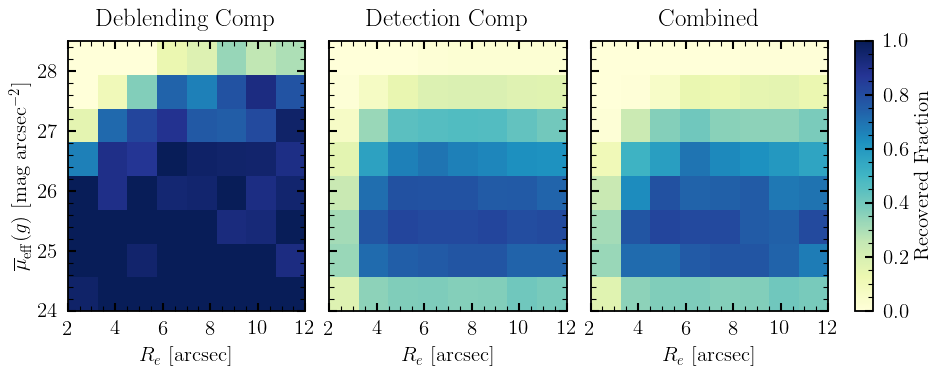

In [260]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.7), sharey=True, sharex=False)

# Deblend + Modeling completeness
plt.sca(axes[0])
im = plt.imshow(deblend_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                cmap='YlGnBu')

# Greco's detection completeness
plt.sca(axes[1])
plt.imshow(
    detection_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )

# Together
plt.sca(axes[2])
plt.imshow(
    detection_map * deblend_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')

axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[0].set_title('Deblending Comp')
axes[1].set_title('Detection Comp')
axes[2].set_title('Combined')


fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.1, hspace=0.3)

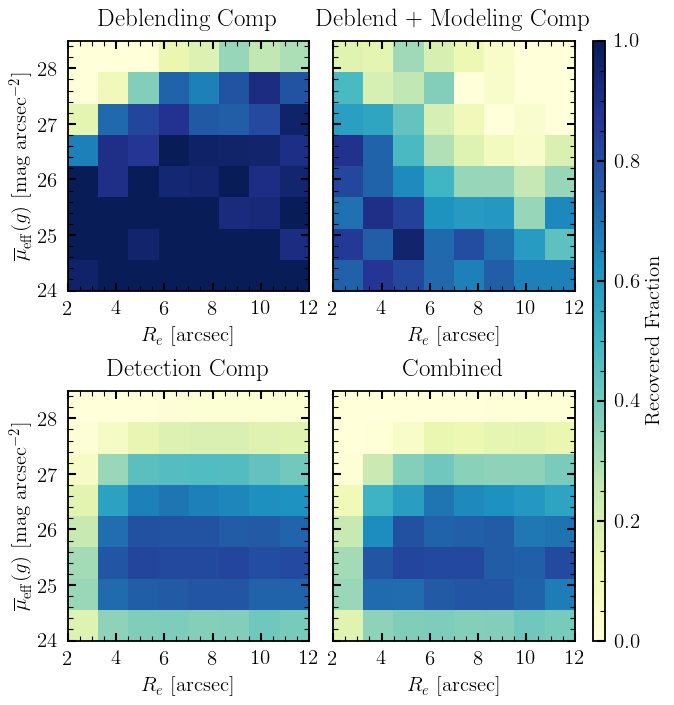

In [259]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=False)

# Deblending completeness
plt.sca(axes[0, 0])
im = plt.imshow(deblend_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                cmap='YlGnBu')
axes[0, 0].set_title('Deblending Comp')

# Deblend + Modeling completeness
plt.sca(axes[0, 1])
im = plt.imshow(deblend_modeling_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                cmap='YlGnBu')
axes[0, 1].set_title('Deblend + Modeling Comp')

# Greco's detection completeness
plt.sca(axes[1, 0])
plt.imshow(
    detection_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )
axes[1, 0].set_title('Detection Comp')

# Together
plt.sca(axes[1, 1])
plt.imshow(
    detection_map * deblend_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )
axes[1, 1].set_title('Combined')

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')

for ax in axes[:, 0]:
    ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')


fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.1, hspace=0.4)